YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X_train shape: (913, 60, 5), y_train shape: (913,)
X_test shape: (184, 60, 5), y_test shape: (184,)

Training RNN with backpropagation...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23

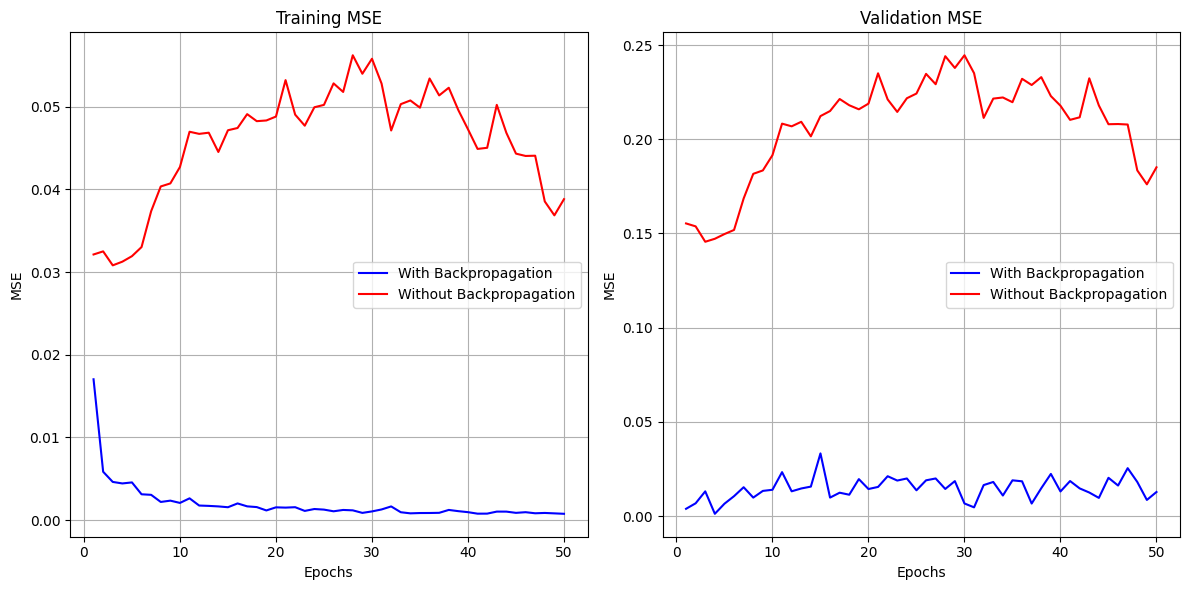


Plotting stock price predictions...


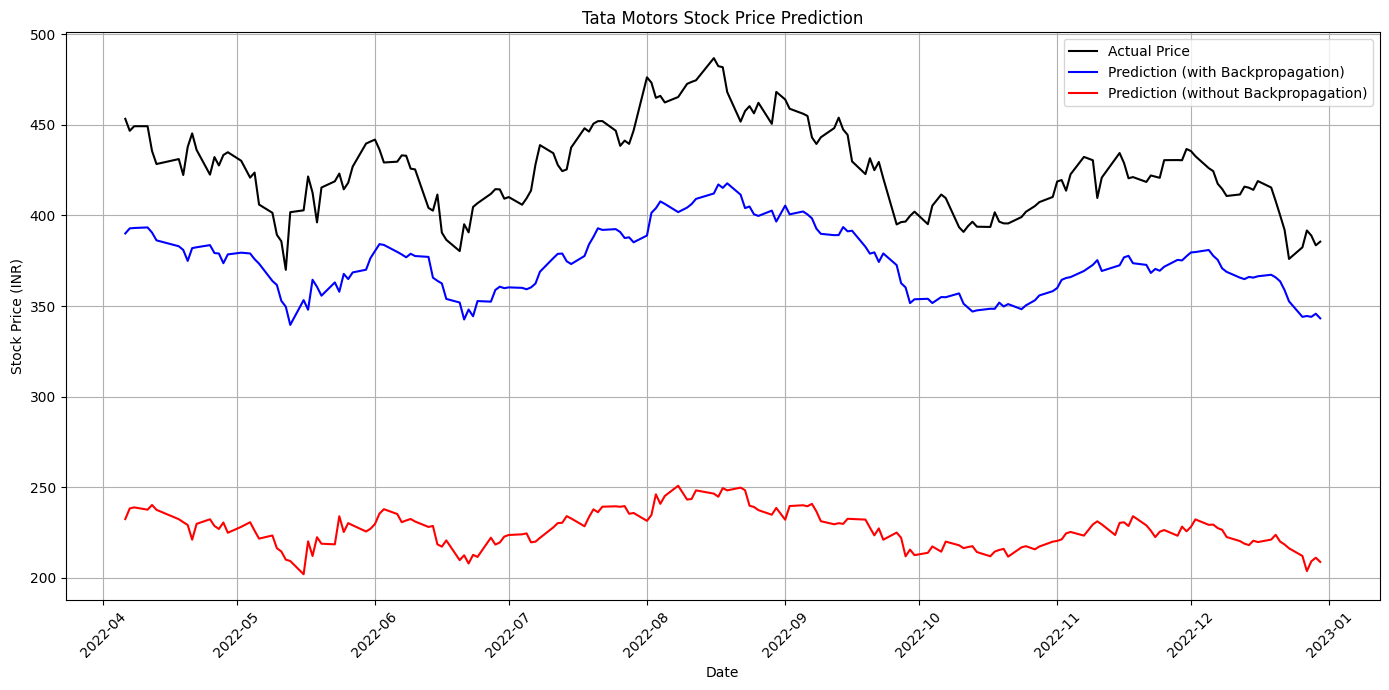

Done!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import math

# Function to download and prepare Tata Motors stock data
def load_and_preprocess_data(ticker='TATAMOTORS.NS', start_date='2018-01-01', end_date='2023-01-01'):
    # Download Tata Motors stock data
    print(f"Downloading {ticker} stock data...")
    data = yf.download(ticker, start=start_date, end=end_date)

    # We'll use the closing price for prediction
    df = data[['Close']].copy()

    # Feature Engineering - Create additional features
    # Add moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()

    # Add price momentum
    df['Price_Change'] = df['Close'].pct_change()
    df['Price_Change_5d'] = df['Close'].pct_change(periods=5)

    # Drop NaN values
    df = df.dropna()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Split into train-test sets (80-20)
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    return train_data, test_data, scaler, df.columns, df

# Function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        # We're predicting the closing price, which is the first column
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Create RNN model
def create_rnn_model(seq_length, n_features):
    model = Sequential([
        SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(seq_length, n_features)),
        Dropout(0.2),
        SimpleRNN(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Custom random weight update (without backpropagation)
class RandomUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, small_update=0.001):
        super(RandomUpdateCallback, self).__init__()
        self.small_update = small_update

    def on_batch_end(self, batch, logs=None):
        # Instead of using backpropagation for weight updates,
        # we randomly update weights by a small amount
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                weights = layer.get_weights()
                # Random small updates to weights
                weights[0] += np.random.normal(0, self.small_update, weights[0].shape)
                if len(weights) > 1:  # If there are biases
                    weights[1] += np.random.normal(0, self.small_update, weights[1].shape)
                layer.set_weights(weights)

# Train RNN with backpropagation
def train_with_backpropagation(X_train, y_train, X_test, y_test, epochs=50):
    model = create_rnn_model(X_train.shape[1], X_train.shape[2])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return history, model

# Train RNN without backpropagation (using random weight updates)
def train_without_backpropagation(X_train, y_train, X_test, y_test, epochs=50):
    model = create_rnn_model(X_train.shape[1], X_train.shape[2])
    # Using a very small learning rate
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-10), metrics=['mse'])

    # Create lists to store metrics
    train_mse = []
    val_mse = []

    # Initial evaluation
    _, train_error = model.evaluate(X_train, y_train, verbose=0)
    _, val_error = model.evaluate(X_test, y_test, verbose=0)
    train_mse.append(train_error)
    val_mse.append(val_error)

    # Train with random updates
    random_updater = RandomUpdateCallback()

    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=1,
            callbacks=[random_updater],
            verbose=0
        )

        # Evaluate after each epoch
        _, train_error = model.evaluate(X_train, y_train, verbose=0)
        _, val_error = model.evaluate(X_test, y_test, verbose=0)
        train_mse.append(train_error)
        val_mse.append(val_error)
        print(f"Training MSE: {train_error:.6f}, Validation MSE: {val_error:.6f}")

    # Create history-like object
    history = {
        'mse': train_mse[1:],  # Skip initial evaluation
        'val_mse': val_mse[1:]  # Skip initial evaluation
    }

    return history, model

# Function to predict and evaluate model performance
def evaluate_model(model, X_test, y_test, scaler, feature_columns):
    # Make predictions
    predictions = model.predict(X_test)

    # If we're using a multi-feature input but single target output, we need to scale back properly
    # Create a dummy array matching the feature dimension
    dummy = np.zeros((len(predictions), len(feature_columns)))
    # Put our predictions in the first column (Close price column)
    dummy[:, 0] = predictions.flatten()

    # Inverse transform to get actual stock prices
    predictions_rescaled = scaler.inverse_transform(dummy)[:, 0]

    # Do the same for actual values
    dummy = np.zeros((len(y_test), len(feature_columns)))
    dummy[:, 0] = y_test
    actual_rescaled = scaler.inverse_transform(dummy)[:, 0]

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(actual_rescaled, predictions_rescaled))

    return predictions_rescaled, actual_rescaled, rmse

# Plot comparison of performance
def plot_comparison(bp_history, no_bp_history, epochs=50):
    plt.figure(figsize=(12, 6))

    # Plot training MSE
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), bp_history['mse'], 'b-', label='With Backpropagation')
    plt.plot(range(1, epochs + 1), no_bp_history['mse'], 'r-', label='Without Backpropagation')
    plt.title('Training MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    # Plot validation MSE
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), bp_history['val_mse'], 'b-', label='With Backpropagation')
    plt.plot(range(1, epochs + 1), no_bp_history['val_mse'], 'r-', label='Without Backpropagation')
    plt.title('Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('rnn_comparison.png')
    plt.show()

# Plot actual vs predicted values
def plot_predictions(dates, actual, bp_pred, no_bp_pred):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, 'k-', label='Actual Price')
    plt.plot(dates, bp_pred, 'b-', label='Prediction (with Backpropagation)')
    plt.plot(dates, no_bp_pred, 'r-', label='Prediction (without Backpropagation)')
    plt.title('Tata Motors Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (INR)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('stock_predictions.png')
    plt.show()

def main():
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Parameters
    ticker = 'TATAMOTORS.NS'  # Tata Motors NSE ticker
    sequence_length = 60       # 60 days of data for each prediction
    epochs = 50

    # Load and preprocess data
    train_data, test_data, scaler, feature_columns, df = load_and_preprocess_data(ticker)

    # Create sequences
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Train RNN with backpropagation
    print("\nTraining RNN with backpropagation...")
    bp_history, bp_model = train_with_backpropagation(
        X_train, y_train, X_test, y_test, epochs=epochs
    )

    # Train RNN without backpropagation
    print("\nTraining RNN without backpropagation (random updates)...")
    no_bp_history, no_bp_model = train_without_backpropagation(
        X_train, y_train, X_test, y_test, epochs=epochs
    )

    # Evaluate both models
    print("\nEvaluating backpropagation model...")
    bp_pred, actual, bp_rmse = evaluate_model(bp_model, X_test, y_test, scaler, feature_columns)

    print("\nEvaluating random update model...")
    no_bp_pred, _, no_bp_rmse = evaluate_model(no_bp_model, X_test, y_test, scaler, feature_columns)

    print("\nFinal Results:")
    print(f"RNN with backpropagation RMSE: {bp_rmse:.4f}")
    print(f"RNN without backpropagation RMSE: {no_bp_rmse:.4f}")
    print(f"Difference: {bp_rmse - no_bp_rmse:.4f}")

    # Plot comparison of MSE
    print("\nPlotting MSE comparison...")
    plot_comparison(bp_history.history, no_bp_history, epochs=epochs)

    # Get dates for the test set
    test_dates = df.index[-(len(test_data)-sequence_length):]

    # Plot stock price predictions
    print("\nPlotting stock price predictions...")
    plot_predictions(test_dates, actual, bp_pred, no_bp_pred)

    print("Done!")

if __name__ == "__main__":
    main()